# Learn SquidPy

https://squidpy.readthedocs.io/en/stable/tutorials.html

In [1]:
import scanpy as sc
import anndata as ad
import squidpy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.22.1 scipy==1.10.1 pandas==2.0.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.8
squidpy==1.2.3


In [3]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# load the pre-processed dataset
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

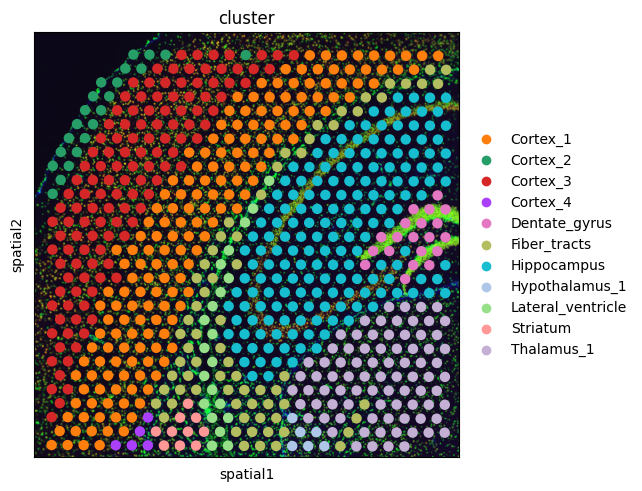

In [6]:
sq.pl.spatial_scatter(adata, color="cluster")

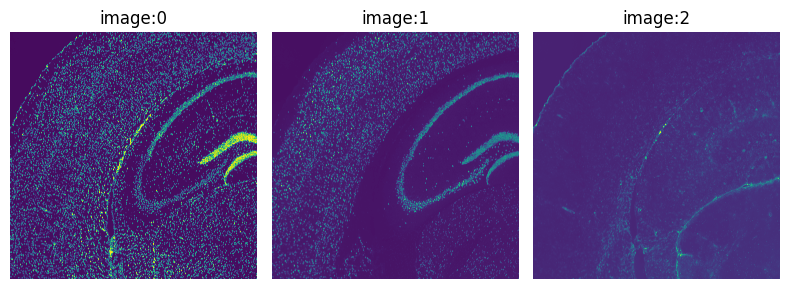

In [7]:
img.show(channelwise=True)

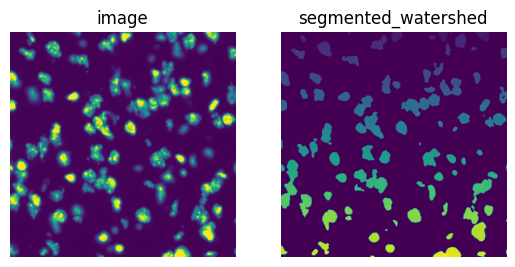

In [8]:
sq.im.process(
    img=img,
    layer="image",
    method="smooth",
)

sq.im.segment(img=img, layer="image_smooth", method="watershed", channel=0, chunks=1000)

# plot the resulting segmentation
fig, ax = plt.subplots(1, 2)
img_crop = img.crop_corner(2000, 2000, size=500)
img_crop.show(layer="image", channel=0, ax=ax[0])
img_crop.show(
    layer="segmented_watershed",
    channel=0,
    ax=ax[1],
)

  0%|          | 0/704 [00:00<?, ?/s]

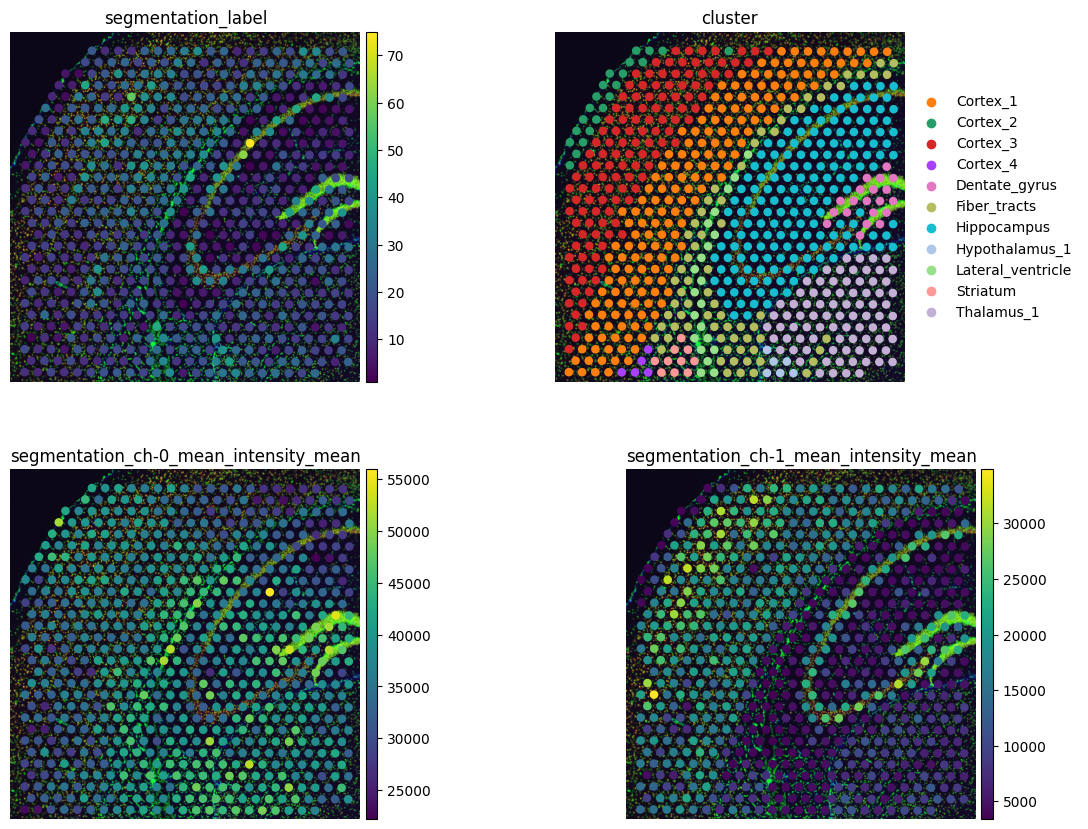

In [9]:
# define image layer to use for segmentation
features_kwargs = {"segmentation": {"label_layer": "segmented_watershed"}}
# calculate segmentation features
sq.im.calculate_image_features(
    adata,
    img,
    features="segmentation",
    layer="image",
    key_added="features_segmentation",
    n_jobs=1,
    features_kwargs=features_kwargs,
)
# plot results and compare with gene-space clustering
sq.pl.spatial_scatter(
    sq.pl.extract(adata, "features_segmentation"),
    color=[
        "segmentation_label",
        "cluster",
        "segmentation_ch-0_mean_intensity_mean",
        "segmentation_ch-1_mean_intensity_mean",
    ],
    frameon=False,
    ncols=2,
)

In [10]:
# define different feature calculation combinations
params = {
    # all features, corresponding only to tissue underneath spot
    "features_orig": {
        "features": ["summary", "texture", "histogram"],
        "scale": 1.0,
        "mask_circle": True,
    },
    # summary and histogram features with a bit more context, original resolution
    "features_context": {"features": ["summary", "histogram"], "scale": 1.0},
    # summary and histogram features with more context and at lower resolution
    "features_lowres": {"features": ["summary", "histogram"], "scale": 0.25},
}

for feature_name, cur_params in params.items():
    # features will be saved in `adata.obsm[feature_name]`
    sq.im.calculate_image_features(adata, img, layer="image", key_added=feature_name, n_jobs=1, **cur_params)

# combine features in one dataframe
adata.obsm["features"] = pd.concat([adata.obsm[f] for f in params.keys()], axis="columns")

# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

  0%|          | 0/704 [00:00<?, ?/s]

  0%|          | 0/704 [00:00<?, ?/s]

  0%|          | 0/704 [00:00<?, ?/s]

In [11]:
def cluster_features(features: pd.DataFrame, like=None):
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]

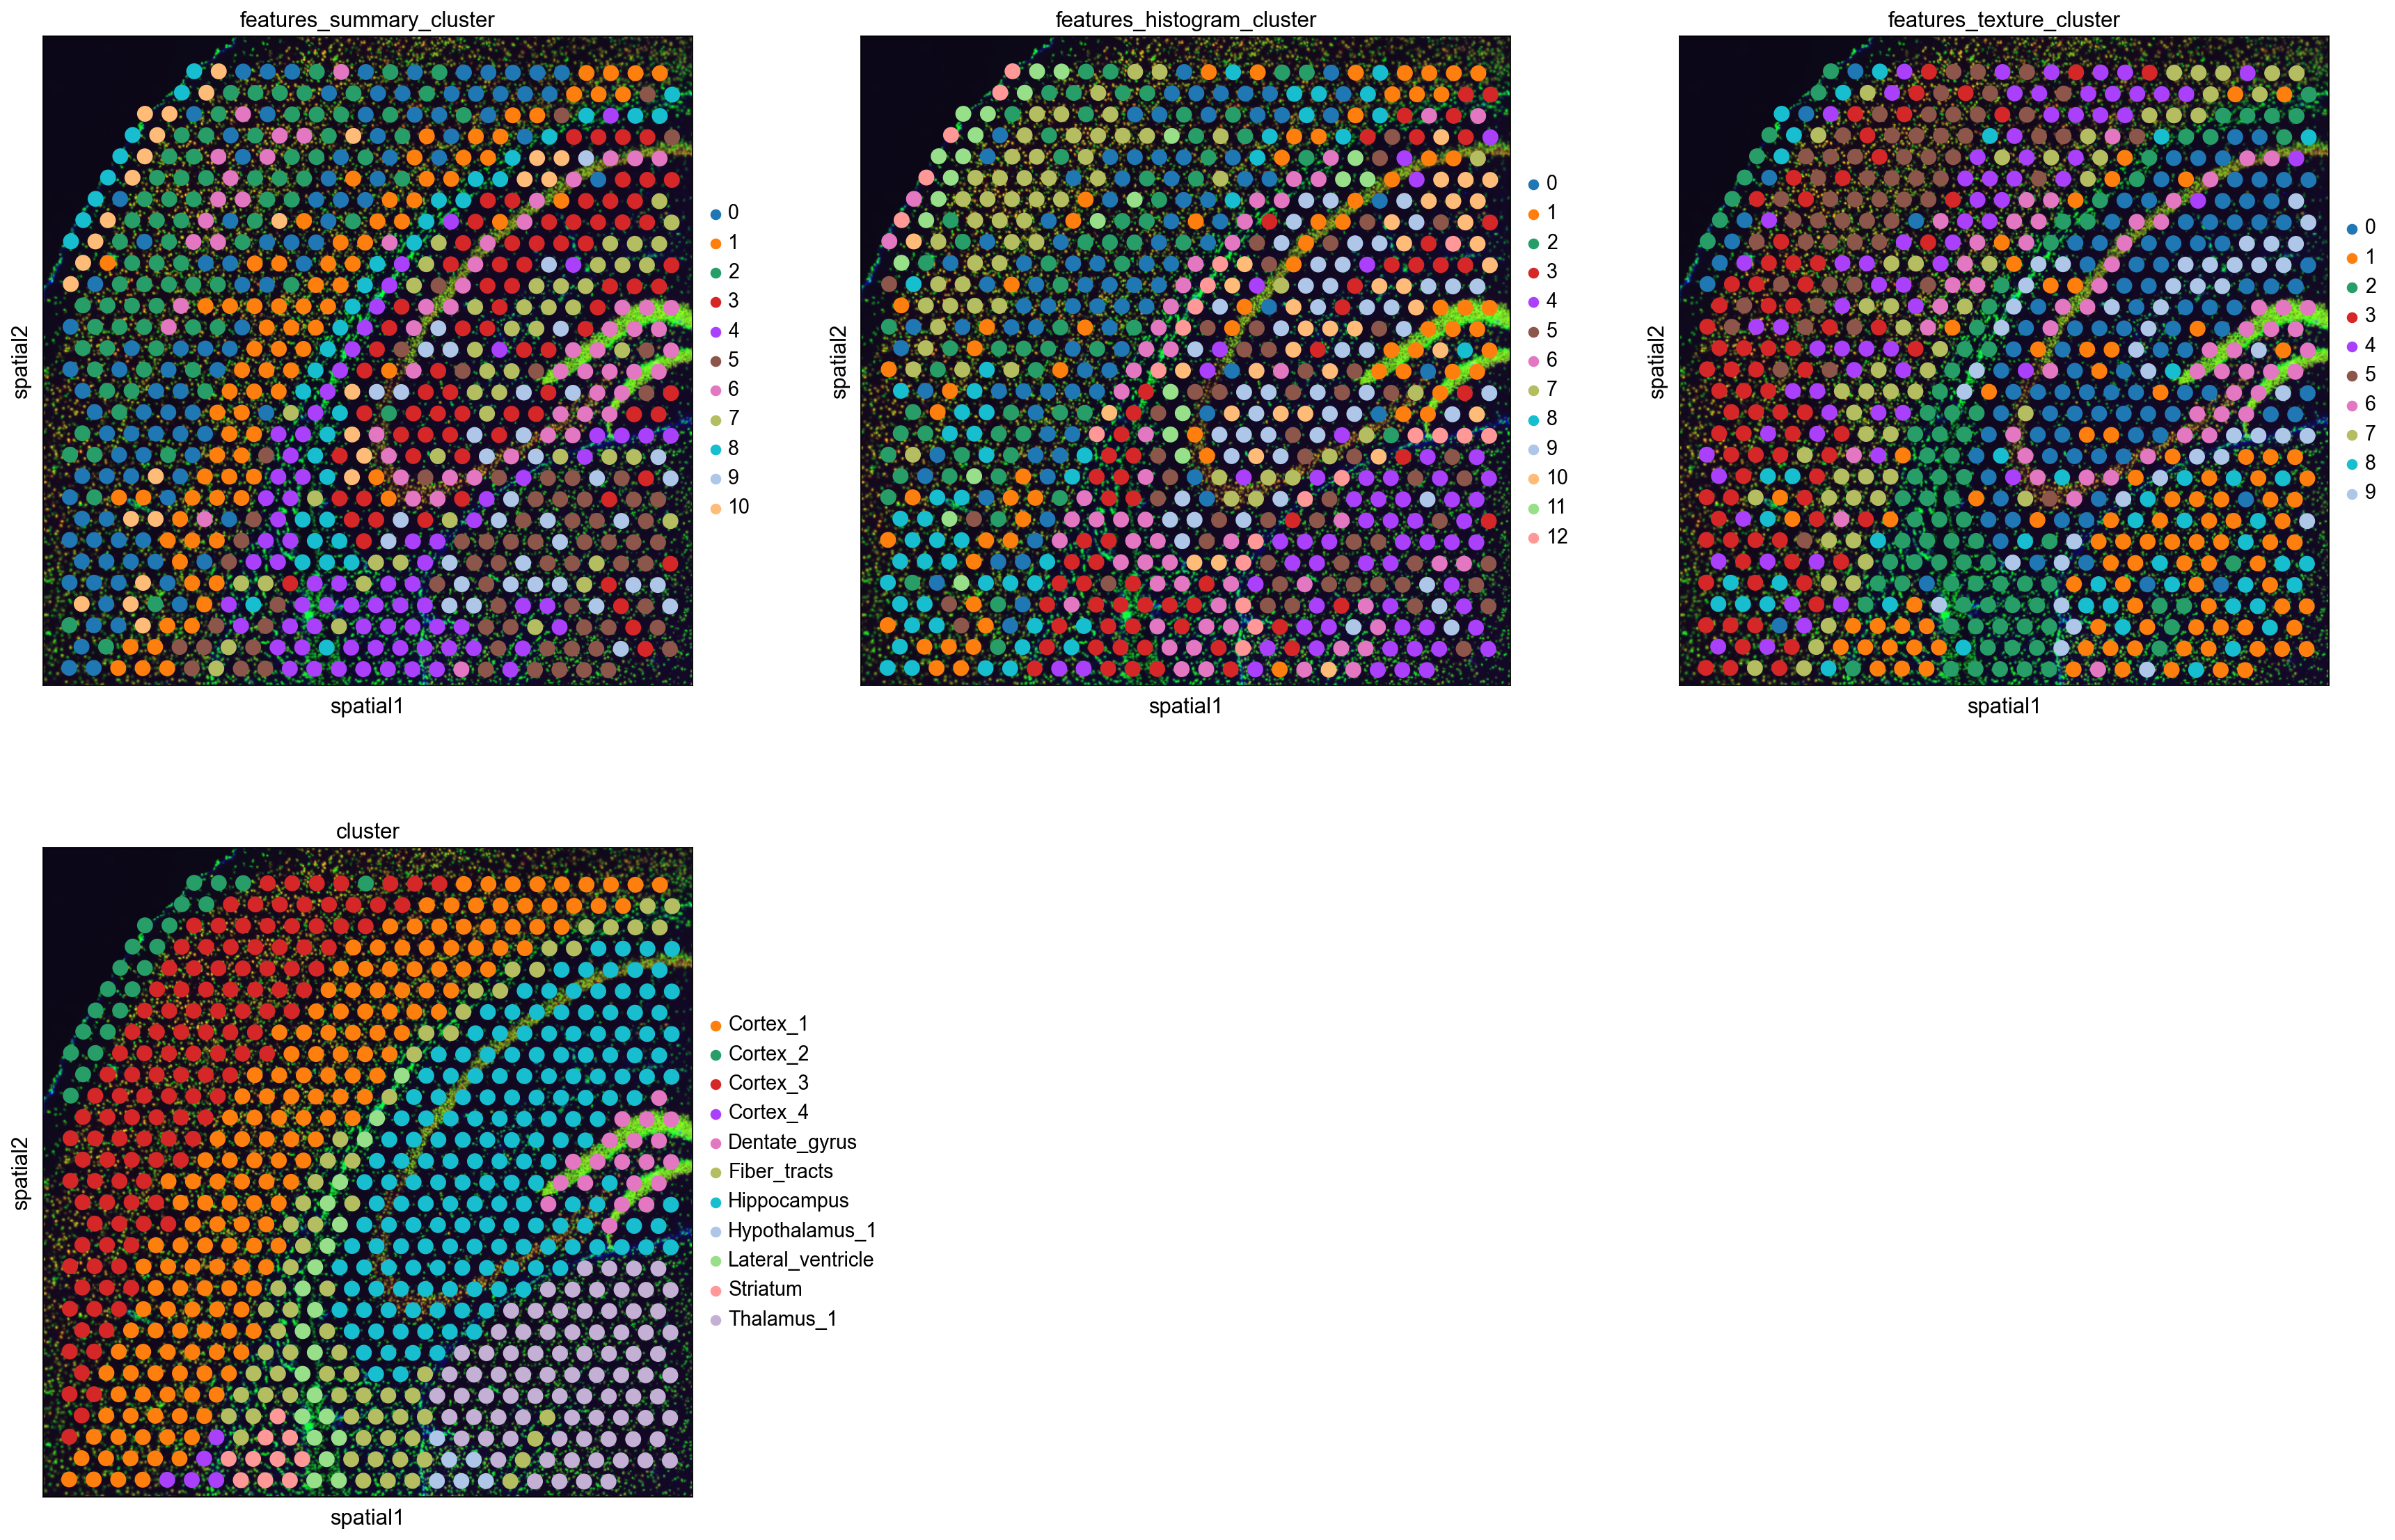

In [12]:
adata.obs["features_summary_cluster"] = cluster_features(adata.obsm["features"], like="summary")
adata.obs["features_histogram_cluster"] = cluster_features(adata.obsm["features"], like="histogram")
adata.obs["features_texture_cluster"] = cluster_features(adata.obsm["features"], like="texture")

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sq.pl.spatial_scatter(
    adata,
    color=[
        "features_summary_cluster",
        "features_histogram_cluster",
        "features_texture_cluster",
        "cluster",
    ],
    ncols=3,
)